# Implementing a Transformer

In this notebook, you will build an Encoder-Decoder Autoregressive Transformer. While the main classes and structures are already provided, you will gradually implement the core functions of the Transformer architecture.

Before diving into the implementation, take a moment to revisit the core components of Transformers. Keep in mind that we will implement an autoregressive encoder-decoder model — try to think this influences its components.

### 0. Warm-up: A brief practice of torch.nn
Our implementation primarily uses `torch.nn` classes, such as `nn.Linear`, `nn.ReLU`, `nn.LayerNorm`, and `nn.Dropout`. These modules offer essential operations such as fully connected layers (`nn.Linear`), activation functions (`nn.ReLU`), and normalization (`nn.LayerNorm`), forming the core building blocks of our model.

Below are some examples. Feel free to play around with the code and make sure that you understand what the different function calls do.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
torch.manual_seed(33)

In [ ]:
my_dim = 20
x = torch.randint(-10,10,(my_dim,)) # Any Random Vector or Matrix
x

In [ ]:
my_relu = nn.ReLU()
my_relu(x)

In [ ]:
my_linear = nn.Linear(my_dim, my_dim*3) # Linear Model
y = torch.randn(my_dim, my_dim) # Any Random Vector or Matrix
output = my_linear(y)
print(output.size())

You can learn more about using `torch.nn` in the official PyTorch documentation: https://pytorch.org/docs/stable/nn.html

### 1. Multi Head Attention

We will start by implementing the key component of Transformers -- Multi-Head Attention (MHA).

This class provides a basic implementation of MHA. Your task is to implement the function `scaled_dot_product_attention`. This function calculates the attetntion vectors as we learned in class. Before starting, ensure you understand the other functions in this class, especially `forward`.  You do not need to implement any algebraic functions manually, everything you need is available in `math` and `torch`.

MHA feeds the representations from the previous layer into multiple attention heads, each with its own learned parameter matrices for queries (Q), keys (K), and values (V). Each head independently computes __scaled dot-product__ attention, as outlined below:

**(1)** The initial attention scores are computed as follows:

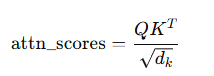

Since Q and K are structured with the first dimension as the batch size and the second as the number of heads, ensure you transpose K correctly across the last two dimensions using:

    K.transpose(-2, -1)

**(2)** Next, the mask is applied, and attention probabilities are computed using the softmax function (use `torch.softmax`). Recall that masking is done with 'minus infinity' so that the resulting probability after softmax is effectively 0.

**(3)** Finally, the output is projected onto the V matrix:

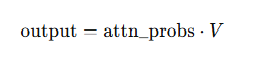

Ensure the function supports both cases — with and without a mask. If a mask is provided, apply it appropriately. Use `-1e9` as "minus infinity" to exclude specific values. Assume that mask has the correct dimensions, where 0 marks values to be ignored. You'll implement this later.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "error"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Parameter(torch.Tensor(num_heads, d_model, self.d_k))
        self.W_k = nn.Parameter(torch.Tensor(num_heads, d_model, self.d_k))
        self.W_v = nn.Parameter(torch.Tensor(num_heads, d_model, self.d_k))
        self.W_o = nn.Linear(d_model, d_model)

        self.init_weights()

    def init_weights(self):
        """Initialize weight matrices with Xavier initialization."""
        for param in [self.W_q, self.W_k, self.W_v]:
            nn.init.xavier_uniform_(param)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        Q (torch.Tensor): Query tensor of shape (batch_size, num_heads, seq_length_q,  d_k).
        K (torch.Tensor): Key tensor of shape (batch_size, num_heads, seq_length_v, d_k).
        V (torch.Tensor): Value tensor of shape (batch_size, num_heads, seq_length_v, d_k).
        mask (torch.Tensor): Mask tensor of shape (1, seq_length_q, seq_length_v), where 0 
                                       indicates masked positions. Default is None.

        Returns:
        torch.Tensor: The output tensor after applying attention, of shape 
                      (batch_size, num_heads, seq_length_q, d_k).
        """
        ## Question 1 - implement this function

        
        ### End of your code

    def forward(self, Q, K, V, mask=None):
        batch_size, seq_len, _ = Q.shape

        # Project each head separately using Einstein summation
        # Q_heads, K_heads, and V_heads each have separate projections per head.
        Q_heads = torch.einsum("bnd,hde->bhne", Q, self.W_q)
        K_heads = torch.einsum("bnd,hde->bhne", K, self.W_k)
        V_heads = torch.einsum("bnd,hde->bhne", V, self.W_v)


        attn_output = self.scaled_dot_product_attention(Q_heads, K_heads, V_heads, mask)
        attn_output = attn_output.transpose(1, 2).reshape(batch_size, seq_len, self.d_model)
        output = self.W_o(attn_output)
        return output


### 2. Feed Forward (MLP) Layer

Now we will be moving to the second building block of Transformers -- the Feed-Forward layers, also known as MLP layers. These layers project each of the input representations into a higher-dimensional space (in our case, we assume `d_ff` is significantly larger than `d_model`). The output is then passed through a non-linear activation function before being projected back to the original model dimension.

**a.** Fill in the dimensions of the weight matrices by replacing the `PLACEHOLDERS` with appropriate class parameters and attributes. Use only predefined attributes, avoiding constant numbers.

**b.** Implement the `forward` function, which processes an input tensor`x` using the Feed-Forward mechanism as described. Utilize the class attributes defined in the `__init__` method.

Recall that the FFN layer operates as follows:

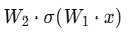

σ represents a non-linear function, while W₁ and W₂ are two linear projections.

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.relu = nn.ReLU()
        ## Question 2a - fill in the dimensions
        self.w1 = nn.Linear(PLACEHOLDER, PLACEHOLDER)
        self.w2 = nn.Linear(PLACEHOLDER, PLACEHOLDER)

    def forward(self, x):
        """
        x (torch.Tensor): input tensor of shape (batch_size, seq_length, d_model).
        """
        ## Question 2b - your code here
        
        
        
        ## End of your code

### 3. Positional Embeddings

Positional embeddings encode the order of tokens in a sequence, which is essential for models like Transformers that process tokens independently. These embeddings are added to token embeddings and can be either sinusoidal (using sine and cosine functions) or learned as trainable parameters to capture word order.

In this section, __you don't need to make any changes__. Simply run the cell and ensure you understand the code.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

### 4. Encoder Layer

In this part, we will use our implementations of MHA and MLP layers to create the Transformer encoder layer. Implement the encoder layer mechanism in the `forward` function. The function should return the tensor after applying all necessary transformations. The argument `x` is the input tensor. We assume that all input sequences have the same length for simplicity, so there is no need to mask out padding tokens.

Remember the residual stream: instead of returning only the updates to the latent tensor, the encoder layer adds these updates and returns an updated version of the input tensor.

Before implementing this section, make sure you understand the usage in `nn.LayerNorm` and `nn.Dropout` class.

Dropout helps preventing overfitting, enhances generalization, and promotes robust feature learning by randomly deactivating neurons during training. This prevents the model from relying too heavily on specific connections, making it more adaptable to new data.

In your code, instead of directly adding the attention output to the residual stream:

    x = x + attn_output

You'll need to apply dropout first:

    x = x + Dropout(attn_output)

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout_rate):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        """
        x (torch.Tensor): input tensor of shape (batch_size, seq_length, d_model).
        """
        ## Question 4 - your code here

        ## End of your code

### 5. Decoder Layer

Implement the decoder layer mechanism in the `forward` function. The function should return the tensor after all necessary transformations. The argument `x` is the decoder input tensor, `enc_output` is the output from the encoder, `no_peak_mask`  ensures that the decoder does not attend to future tokens, preserving the autoregressive nature of the model. You'll implement this mask in the next section, but for now, assume it works as expected.

Be sure to revisit the attention mechanism - make sure you understand the difference between the self-attention and the cross-attention and using them correctly.

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, enc_output, no_peak_mask):
        """
        x (torch.Tensor): input tensor of shape (batch_size, target_seq_length, d_model).
        enc_output (torch.Tensor): the encoder output, tensor of shape (batch_size, source_seq_length, d_model).
        no_peak_mask (torch.Tensor): the mask for the decoder, tensor of shape (1, target_seq_length, target_seq_length).

        """
        ## Question 5 - your code here

        ## End of your code

### 6. Building the Transformer itself!

Now that we have all the building blocks, we can assemble the full Transformer! Review the `__init__` function to see the components we’ve implemented. The forward function is already provided, showing the full pass through the model.

Implement the `generate_mask` function to create the no-peak mask for the decoder, that allows each token to attend only to itself and earlier tokens, blocking future positions. The mask should have a shape of `(1, target_sequence_len, target_sequence_len)`. The value at position (0, i, j) in this tensor should be 1 if token i is allowed to attend to token j, and 0 if it should be masked out.

You might find `torch.ones` and `torct.triu` useful for this task.

In [ ]:
class CausalTransformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(CausalTransformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, tgt):
        """
        tgt (torch.Tensor): the target sequence, tensor of shape (batch_size, target_seq_length)
        
        Returns:
        torch.Tensor: a no peak map for the target_data, of shape 
                      (1, seq_length, seq_length).
        """
        ## Question 6 - your code here

        ## End of your code

    def forward(self, src, tgt):
        np_mask = self.generate_mask(tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, np_mask)

        output = self.fc(dec_output)
        return output

### 7. Testing your Transformer

Run the following cells to test your transformer! This code generates random data and trains the model. Make sure you understand how it works.

__Let it run for 10 training epochs to confirm that you’ve implemented a functioning transformer.__


In [ ]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = CausalTransformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(10):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Good job!